# Gaia Epoch Astrometry: Simulation + Fitting Tutorial
This notebook demonstrates the `gaia-epochfit` package workflow:
1) Resolve a target by SIMBAD
2) Simulate Gaia-like epoch astrometry (AL-only) using `astromet.py`
3) Fit N-planet orbits with the Exoplanet/PyMC backend

> **Note:** Make sure you have installed dependencies (see README).

In [1]:
# If running from the repository root, add the src/ path without installing
import sys, os
sys.path.append(os.path.abspath("src"))

import numpy as np
import matplotlib.pyplot as plt

import astromet
from gaia_epochfit import SimulationAndFit
from gaia_epochfit.utils import PlanetParams
from gaia_epochfit.resolve import resolve_star
from gaia_epochfit.visualize import plot_scan_geometry




In [2]:
pipe = SimulationAndFit(backend='exoplanet')

# ε Eri b–like orbit (order-of-magnitude realistic; tweak as you wish)
planets = [
    PlanetParams(
        period_yr=7.4,     # ~7.3–7.6 yr
        a_au=3.5,          # AU
        e=0.07,
        i_deg=0.0,        # inclination guess; update if you have a prior
        omega_deg=90.0,
        Omega_deg=30.0,
        tp_jyr=2016.0,     # time of periastron (adjustable)
        m_jup=100         # M_Jup
    )
]

star_params = resolve_star('HR 3384')
sim = pipe.simulate(
    target_name='HR 3384',
    star_mass_msun=0.82,
    planets=planets,
    epoch_range=(2014.6, 2020.1)
)


sim.keys()




dict_keys(['resolved', 'ts', 'phis', 'rac_true', 'dec_true', 't_obs', 'x_obs', 'phi_obs', 'rac_obs', 'dec_obs'])

In [3]:
type(star_params)

gaia_epochfit.resolve.ResolvedTarget

In [4]:
# --- pull what we need from `sim` ---
ts      = sim["ts"]                 # epoch grid used for true track (years)
phis    = sim["phis"]
racs    = sim["rac_true"]           # true RA*cosDec offsets [mas]
decs    = sim["dec_true"]           # true Dec offsets [mas]

t_obs   = sim["t_obs"]              # CCD-bundle times (years)
x_obs   = sim["x_obs"]              # along-scan measurements [mas]
phi_obs = sim["phi_obs"]            # scan angles at each bundle [deg]
rac_obs = sim["rac_obs"]            # projected RA*cosDec centers of bundles [mas]
dec_obs = sim["dec_obs"]            # projected Dec centers of bundles [mas]

# the simulation used a single mag for AL errors; use the same here
al_err   = astromet.sigma_ast(star_params.gaia_mag)  # mas

In [12]:
params = astromet.simple_fit(ts,racs,decs,al_err,rac_obs,dec_obs)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

(<Figure size 1200x700 with 1 Axes>,
 <Axes: title={'center': 'True track (black) and 1D Gaia AL segments (orange)'}, xlabel='$RA\\cos(\\mathrm{Dec})$ [mas]', ylabel='$Dec$ [mas]'>,
 array([-0.03702888,  0.05301335, -0.02536835, -0.02471722, -0.02462701,
        -0.02441197, -0.0243215 , -0.00124371, -0.00115643, -0.0009493 ,
        -0.01205742, -0.01201565,  0.02241956,  0.0020995 ,  0.0020713 ,
         0.03573281,  0.03565616,  0.0249506 ,  0.02487378, -0.05086451,
        -0.05097791,  0.04041659,  0.04038143, -0.03439154, -0.05180024,
        -0.05172892, -0.02316398, -0.02308111, -0.02288435, -0.02126114,
        -0.02117623,  0.00593612,  0.00601266,  0.00619365, -0.00971925,
        -0.00969138,  0.02511585,  0.02509119,  0.00589791,  0.03961154,
         0.03953335,  0.03934565,  0.02932396,  0.02924548, -0.0467908 ,
         0.04296992, -0.03199388, -0.0456319 , -0.04554767, -0.02036724,
        -0.02015539, -0.02006655, -0.01869195, -0.01861496, -0.00720923,
         0.0276

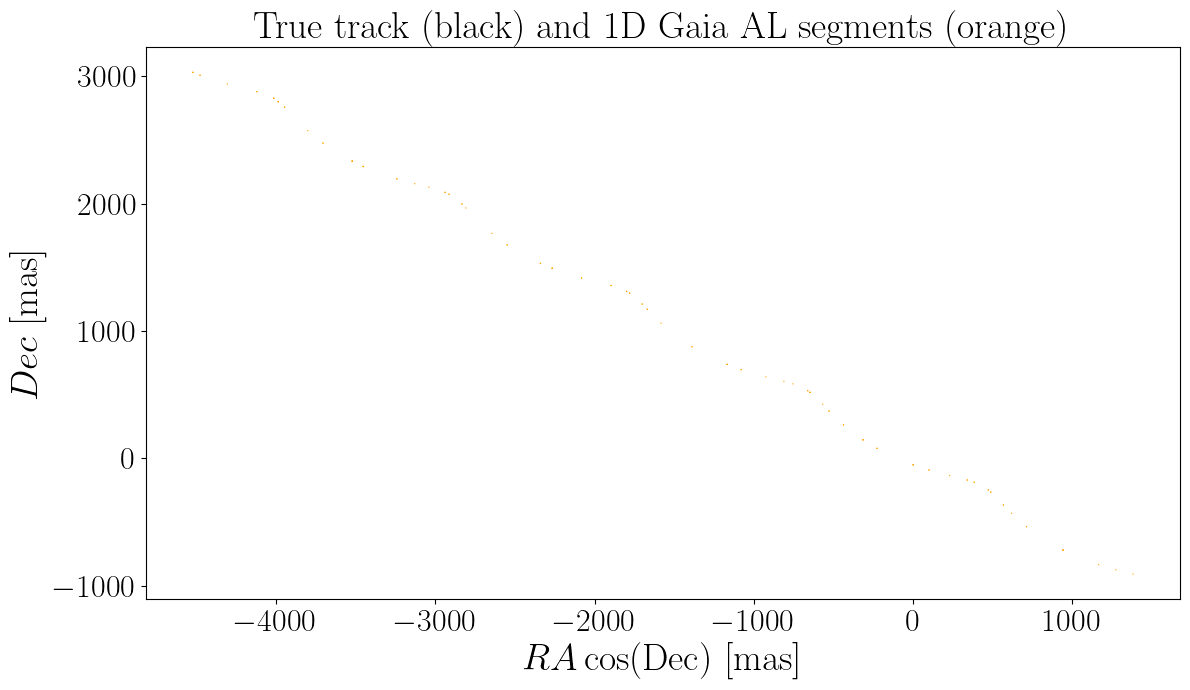

In [5]:
plot_scan_geometry(astromet.params(), sim)

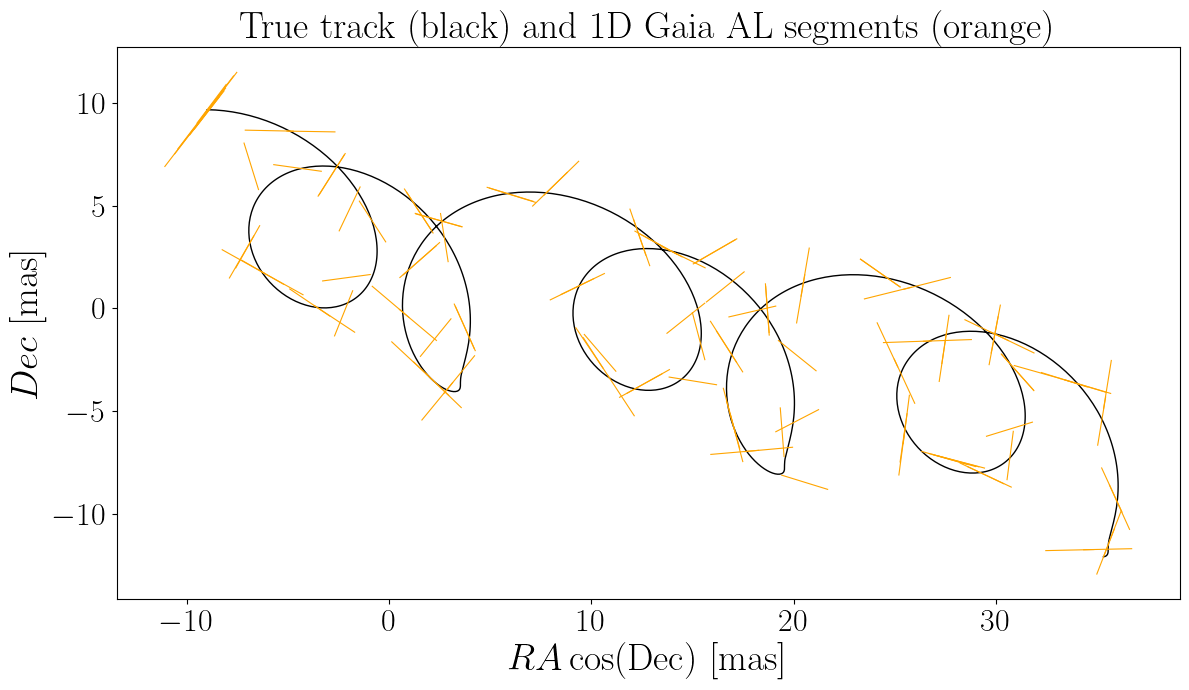

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import astromet

from gaia_epochfit.gaia_epochs import nominal_times_and_angles
from gaia_epochfit.visualize import plot_scan_geometry


params=astromet.params()


ra=160
dec=-50


params.ra=ra
params.dec=dec
params.drac=0
params.ddec=0
params.pmrac=8
params.pmdec=-2
params.parallax=5

params.period=2
params.a=2
params.e=0.8
params.q=0.5
params.l=0.1

params.vphi=4.5
params.vtheta=1.5
params.vomega=5.6

params.tperi=2016

racs,decs=astromet.track(ts,params)




# --- choose sky position & window (use the same RA/Dec you've set above) ---
ra = params.ra      # [deg]
dec = params.dec    # [deg]
tstart, tend = 2014.6, 2020.1      # DR4-like, match tutorial window if needed

# 1) Gaia scanning-law per-transit epochs and angles
ts, phis_rad = nominal_times_and_angles(ra, dec, tstart=tstart, tend=tend)

# 2) True COL track from the same astromet params (tutorial code)
racs_true, decs_true = astromet.track(ts, params)  # [mas], in local ΔRAcosDec/ΔDec

# 3) Build a minimal 'sim' dict that your plotter expects
sim = {
    "ts": ts,                              # transit times [yr]
    "phis": np.degrees(phis_rad),          # scan angles [deg] for plotting function
    "rac_true": racs_true,                 # true ΔRA*cosDec [mas]
    "dec_true": decs_true,                 # true ΔDec [mas]
    "resolved": type("T", (), {"gaia_mag": 18.0})(),  # stub target with G mag (optional)
}

# 4) Plot: black = true track, orange = 1D AL segments (±σ_AL) like the tutorial
fig, ax, radphi = plot_scan_geometry(params, sim, mag=18.0)   # pass 18 explicitly to match the docs example
plt.show()


In [7]:
ratios = np.abs(np.tan(radphi))
ratios = np.where(ratios < 1, 1 / ratios, ratios)
print(np.mean(ratios))

5.166780266082652


In [8]:
pipe = SimulationAndFit(backend='exoplanet')

# ε Eri b–like orbit (order-of-magnitude realistic; tweak as you wish)
planets = [
    PlanetParams(
        period_yr=7.4,     # ~7.3–7.6 yr
        a_au=3.5,          # AU
        e=0.07,
        i_deg=0.0,        # inclination guess; update if you have a prior
        omega_deg=90.0,
        Omega_deg=30.0,
        tp_jyr=2016.0,     # time of periastron (adjustable)
        m_jup=100         # M_Jup
    )
]

star_params = resolve_star('HR 3384')
sim = pipe.simulate(
    target_name='HR 3384',
    star_mass_msun=0.82,
    planets=planets,
    epoch_range=(2014.6, 2020.1)
)


sim.keys()


dict_keys(['resolved', 'ts', 'phis', 'rac_true', 'dec_true', 't_obs', 'x_obs', 'phi_obs', 'rac_obs', 'dec_obs'])

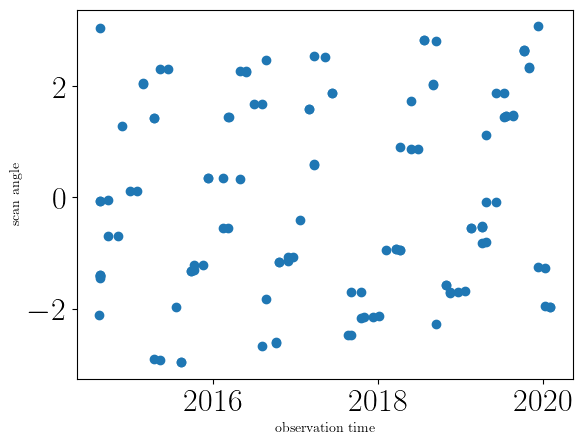

In [9]:
ax=plt.gca()
ax.scatter(ts,phis)
ax.set_xlabel(r'observation time')
ax.set_ylabel(r'scan angle')
plt.show()

In [10]:
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u

t = np.asarray(sim["t_obs"])
print("window:", t.min(), t.max(), "Δ=", t.max()-t.min(), "yr")

c = SkyCoord(sim['resolved'].ra_deg*u.deg, sim['resolved'].dec_deg*u.deg, frame='icrs')
beta = c.barycentrictrueecliptic.lat.deg
print("ecliptic latitude β =", beta)

# Are we accidentally keeping the ecliptic-pole scanning stretch (EPSL)?
epsl = (t >= 2014.57) & (t <= 2014.65)   # ~first month; coarse window
print("EPSL visits in window:", int(epsl.sum()))


window: 2014.8322802155108 2020.0592073262947 Δ= 5.22692711078389 yr
ecliptic latitude β = -49.740887655754285
EPSL visits in window: 0


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import astromet

# 1) Rebuild the base (5-parameter) track that includes only pm + parallax
p = astromet.params()
p.ra   = sim['resolved'].ra_deg
p.dec  = sim['resolved'].dec_deg
p.pmrac   = sim['resolved'].pmra_masyr or 0.0
p.pmdec   = sim['resolved'].pmdec_masyr or 0.0
p.parallax = sim['resolved'].plx_mas
p.epoch    = 2016.0  # same reference epoch as in your pipeline

base_rac, base_dec = astromet.track(sim['ts'], p)  # [mas], no planetary reflex

# 2) Subtract the base track from the full track to isolate the planetary reflex
reflex_ra  = sim['rac_true'] - base_rac
reflex_dec = sim['dec_true'] - base_dec

# 3) Check the reflex amplitude (should be a few mas)
amp_ra  = np.ptp(reflex_ra)/2
amp_dec = np.ptp(reflex_dec)/2
print(f"Reflex semi-amplitude ~ {amp_ra:.2f} mas (RA*), {amp_dec:.2f} mas (Dec)")

# 4) Plot: parallax ellipse vs orbit-only reflex
fig, ax = plt.subplots(1, 2, figsize=(10,4))

# Left: full motion (parallax + pm + reflex) over the simulation span
ax[0].plot(sim['rac_true'], sim['dec_true'], lw=1.0, color='0.2')
ax[0].set_title("Full sky-plane motion (parallax dominates)")
ax[0].set_xlabel(r'$RA\cos(Dec)$ [mas]')
ax[0].set_ylabel(r'$Dec$ [mas]')
ax[0].axis('equal')

# Right: reflex-only (parallax/pm removed)
ax[1].plot(reflex_ra, reflex_dec, lw=1.2, color='C0')
ax[1].set_title("Planetary reflex (parallax & pm removed)")
ax[1].set_xlabel(r'$RA\cos(Dec)$ [mas]')
ax[1].set_ylabel(r'$Dec$ [mas]')
ax[1].axis('equal')

plt.tight_layout()
plt.show()


Reflex semi-amplitude ~ 0.00 mas (RA*), 0.00 mas (Dec)


RuntimeError: latex was not able to process the following string:
b'Planetary reflex (parallax & pm removed)'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error file.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.24 (TeX Live 2022) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./file.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-02-24>
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2022/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2022/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2022/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2022/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2022/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file file.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Misplaced alignment tab character &.
l.30 {\rmfamily Planetary reflex (parallax &
                                             pm removed)}%
No pages of output.
Transcript written on file.log.




Error in callback <function _draw_all_if_interactive at 0x105e10f40> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'Planetary reflex (parallax & pm removed)'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error file.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.24 (TeX Live 2022) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./file.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-02-24>
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2022/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2022/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2022/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2022/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2022/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file file.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Misplaced alignment tab character &.
l.30 {\rmfamily Planetary reflex (parallax &
                                             pm removed)}%
No pages of output.
Transcript written on file.log.




RuntimeError: latex was not able to process the following string:
b'Planetary reflex (parallax & pm removed)'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error file.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.24 (TeX Live 2022) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./file.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-02-24>
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2022/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2022/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2022/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2022/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2022/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file file.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Misplaced alignment tab character &.
l.30 {\rmfamily Planetary reflex (parallax &
                                             pm removed)}%
No pages of output.
Transcript written on file.log.




<Figure size 1000x400 with 2 Axes>

In [ ]:
# use the same AL error as in your sim
al_err = astromet.sigma_ast(8.0)  # set to your sim magnitude
radphi = np.deg2rad(sim['phi_obs'])

# Project the base track at observation times, then remove it from the obs centers
# so the orange segments show only the reflex component
# (we'll interpolate base to t_obs for a clean removal)
base_rac_obs = np.interp(sim['t_obs'], sim['ts'], base_rac)
base_dec_obs = np.interp(sim['t_obs'], sim['ts'], base_dec)

rac_centers = sim['rac_obs'] - base_rac_obs
dec_centers = sim['dec_obs'] - base_dec_obs

x1 = rac_centers - al_err*np.sin(radphi)
x2 = rac_centers + al_err*np.sin(radphi)
y1 = dec_centers - al_err*np.cos(radphi)
y2 = dec_centers + al_err*np.cos(radphi)

# Smooth line of reflex-only track
plotts = np.linspace(sim['ts'].min(), sim['ts'].max(), 1000)
reflex_ra_line  = np.interp(plotts, sim['ts'], reflex_ra)
reflex_dec_line = np.interp(plotts, sim['ts'], reflex_dec)

fig, ax = plt.subplots(figsize=(5.5,5))
for i in range(sim['t_obs'].size):
    ax.plot([x1[i], x2[i]], [y1[i], y2[i]], c='orange', lw=0.7, alpha=0.6)
ax.plot(reflex_ra_line, reflex_dec_line, c='k', lw=1.2)
ax.set_xlabel(r'$RA\cos(Dec)$ [mas]')
ax.set_ylabel(r'$Dec$ [mas]')
ax.set_title('Reflex-only: 1D Gaia measurements over true track')
ax.axis('equal')
plt.show()


In [ ]:
# Quick look at the simulated along-scan data
import matplotlib.pyplot as plt
t = sim['t_obs']
x = sim['x_obs']
plt.figure()
plt.plot(t, x, '.')
plt.xlabel("Time [Julian year]")
plt.ylabel("AL displacement [mas]")
plt.title("Simulated Gaia AL measurements")
plt.show()


In [ ]:
# Run a short Exoplanet/PyMC fit (reduce draws for speed in demo)
idata = pipe.fit(sim, star_mass_msun=1.8, backend_kwargs=dict(n_planets=1, mag=8.0, draws=500, tune=500))
idata


In [ ]:
# Posterior predictive check: overplot model mean AL signal
import numpy as np
# In this skeleton we didn't store the deterministic model; for a quick preview,
# we just overlay a running mean of x_obs as a placeholder visual.
t = sim['t_obs']
x = sim['x_obs']
plt.figure()
plt.plot(t, x, '.', alpha=0.5)
# Simple smoothing for visualization only
from scipy.ndimage import gaussian_filter1d
plt.plot(t, gaussian_filter1d(x, 5))
plt.xlabel("Time [Julian year]")
plt.ylabel("AL displacement [mas]")
plt.title("Observed vs smoothed (visual aid)")
plt.show()
